# 1. Import necessary libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet, InceptionV3, VGG19, EfficientNetB4
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.pyplot import imshow
from PIL import Image

import numpy as np
import pandas as pd
import shutil
import cv2 as cv2
import matplotlib.pyplot as plt
import os
import seaborn as sns
sns.set_style("darkgrid")

# 2. Define some functions

**Function to show data sample**

In [2]:
def show_image_samples(gen):
    t_dict = gen.class_indices
    classes = list(t_dict.keys())
    images, labels = next(gen)  # get a sample batch from the generator
    plt.figure(figsize=(20, 20))
    length = len(labels)
    if length < 25:  # show maximum of 25 images
        r = length
    else:
        r = 25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color="blue", fontsize=12)
        plt.axis("off")
    plt.show()

**Function to print text in RGB foreground and background colors¶**

In [3]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    # prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple
    # text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf, gf, bf = fore_tupple
    rb, gb, bb = back_tupple
    msg = "{0}" + txt_msg
    mat = ("\33[38;2;" + str(rf) + ";" + str(gf) + ";" + str(bf) + ";48;2;" + str(rb) + ";" + str(gb) + ";" + str(bb) + "m")
    print(msg.format(mat), flush=True)
    print("\33[0m", flush=True)  # returns default print color to back to black
    return

**Function to plot the training data**

In [4]:
def tr_plot(tr_data, start_epoch):
    # Plot the training and validation data
    tacc = tr_data.history["accuracy"]
    tloss = tr_data.history["loss"]
    vacc = tr_data.history["val_accuracy"]
    vloss = tr_data.history["val_loss"]
    Epoch_count = len(tacc) + start_epoch
    Epochs = []
    for i in range(start_epoch, Epoch_count):
        Epochs.append(i + 1)
    index_loss = np.argmin(vloss)  #  this is the epoch with the lowest validation loss
    val_lowest = vloss[index_loss]
    index_acc = np.argmax(vacc)
    acc_highest = vacc[index_acc]
    plt.style.use("fivethirtyeight")
    sc_label = "best epoch= " + str(index_loss + 1 + start_epoch)
    vc_label = "best epoch= " + str(index_acc + 1 + start_epoch)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    axes[0].plot(Epochs, tloss, "r", label="Training loss")
    axes[0].plot(Epochs, vloss, "g", label="Validation loss")
    axes[0].scatter(
        index_loss + 1 + start_epoch, val_lowest, s=150, c="blue", label=sc_label
    )
    axes[0].set_title("Training and Validation Loss")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Loss")
    axes[0].legend()
    axes[1].plot(Epochs, tacc, "r", label="Training Accuracy")
    axes[1].plot(Epochs, vacc, "g", label="Validation Accuracy")
    axes[1].scatter(
        index_acc + 1 + start_epoch, acc_highest, s=150, c="blue", label=vc_label
    )
    axes[1].set_title("Training and Validation Accuracy")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()
    plt.tight_layout
    plt.show()

**Function to create confusion matrix and classification report**

In [5]:
def print_info(test_gen, preds, print_code, save_dir, subject):
    class_dict = test_gen.class_indices
    labels = test_gen.labels
    file_names = test_gen.filenames
    error_list = []
    true_class = []
    pred_class = []
    prob_list = []
    new_dict = {}
    error_indices = []
    y_pred = []
    for key, value in class_dict.items():
        new_dict[value] = (
            key  # dictionary {integer of class number: string of class name}
        )
    # store new_dict as a text fine in the save_dir
    classes = list(new_dict.values())  # list of string of class names
    errors = 0
    for i, p in enumerate(preds):
        pred_index = np.argmax(p)
        true_index = labels[i]  # labels are integer values
        if pred_index != true_index:  # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)
            errors = errors + 1
        y_pred.append(pred_index)
    if print_code != 0:
        if errors > 0:
            if print_code > errors:
                r = errors
            else:
                r = print_code
            msg = "{0:^28s}{1:^28s}{2:^28s}{3:^16s}".format(
                "Filename", "Predicted Class", "True Class", "Probability"
            )
            print_in_color(msg, (0, 255, 0), (55, 65, 80))
            for i in range(r):
                split1 = os.path.split(error_list[i])
                split2 = os.path.split(split1[0])
                fname = split2[1] + "/" + split1[1]
                msg = "{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}".format(
                    fname, pred_class[i], true_class[i], " ", prob_list[i]
                )
                print_in_color(msg, (255, 255, 255), (55, 65, 60))
                # print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])
        else:
            msg = "With accuracy of 100 % there are no errors to print"
            print_in_color(msg, (0, 255, 0), (55, 65, 80))
    if errors > 0:
        plot_bar = []
        plot_class = []
        for key, value in new_dict.items():
            count = error_indices.count(key)
            if count != 0:
                plot_bar.append(
                    count
                )  # list containg how many times a class c had an error
                plot_class.append(value)  # stores the class
        fig = plt.figure()
        fig.set_figheight(len(plot_class) / 3)
        fig.set_figwidth(10)
        plt.style.use("fivethirtyeight")
        for i in range(0, len(plot_class)):
            c = plot_class[i]
            x = plot_bar[i]
            plt.barh(
                c,
                x,
            )
            plt.title(" Errors by Class on Test Set")
    y_true = np.array(labels)
    y_pred = np.array(y_pred)
    if len(classes) <= 30:
        # create a confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        length = len(classes)
        if length < 8:
            fig_width = 8
            fig_height = 8
        else:
            fig_width = int(length * 0.5)
            fig_height = int(length * 0.5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt="g", cmap="Blues", cbar=False)
        plt.xticks(np.arange(length) + 0.5, classes, rotation=90)
        plt.yticks(np.arange(length) + 0.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

**Function to save the model and the associated class_dict.csv file**

In [6]:
def saver(save_path, model, model_name, subject, accuracy, img_size, scalar, generator):
    # first save the model
    save_id = str(
        model_name + "-" + subject + "-" + str(acc)[: str(acc).rfind(".") + 3] + ".h5"
    )
    model_save_loc = os.path.join(save_path, save_id)
    model.save(model_save_loc)
    print_in_color("model was saved as " + model_save_loc, (0, 255, 0), (55, 65, 80))
    # now create the class_df and convert to csv file
    class_dict = generator.class_indices
    height = []
    width = []
    scale = []
    for i in range(len(class_dict)):
        height.append(img_size[0])
        width.append(img_size[1])
        scale.append(scalar)
    Index_series = pd.Series(list(class_dict.values()), name="class_index")
    Class_series = pd.Series(list(class_dict.keys()), name="class")
    Height_series = pd.Series(height, name="height")
    Width_series = pd.Series(width, name="width")
    Scale_series = pd.Series(scale, name="scale by")
    class_df = pd.concat(
        [Index_series, Class_series, Height_series, Width_series, Scale_series], axis=1
    )
    csv_name = "class_dict.csv"
    csv_save_loc = os.path.join(save_path, csv_name)
    class_df.to_csv(csv_save_loc, index=False)
    print_in_color(
        "class csv file was saved as " + csv_save_loc, (0, 255, 0), (55, 65, 80)
    )
    return model_save_loc, csv_save_loc

**Function that uses the trained model and the class_dict.csv file to predict images**

In [7]:
def predictor(sdir, csv_path, model_path, crop_image=False):
    # read in the csv file
    class_df = pd.read_csv(csv_path)
    img_height = int(class_df["height"].iloc[0])
    img_width = int(class_df["width"].iloc[0])
    img_size = (img_width, img_height)
    scale = class_df["scale by"].iloc[0]
    try:
        s = int(scale)
        s2 = 1
        s1 = 0
    except:
        split = scale.split("-")
        s1 = float(split[1])
        s2 = float(split[0].split("*")[1])
        print(s1, s2)
    path_list = []
    paths = os.listdir(sdir)
    for f in paths:
        path_list.append(os.path.join(sdir, f))
    print(" Model is being loaded- this will take about 10 seconds")
    model = load_model(model_path)
    image_count = len(path_list)
    index_list = []
    prob_list = []
    cropped_image_list = []
    good_image_count = 0
    for i in range(image_count):
        img = cv2.imread(path_list[i])
        if crop_image == True:
            status, img = crop(img)
        else:
            status = True
        if status == True:
            good_image_count += 1
            img = cv2.resize(img, img_size)
            cropped_image_list.append(img)
            img = img * s2 - s1
            img = np.expand_dims(img, axis=0)
            p = np.squeeze(model.predict(img))
            index = np.argmax(p)
            prob = p[index]
            index_list.append(index)
            prob_list.append(prob)
    if good_image_count == 1:
        class_name = class_df["class"].iloc[index_list[0]]
        probability = prob_list[0]
        img = cropped_image_list[0]
        plt.title(class_name, color="blue", fontsize=16)
        plt.axis("off")
        plt.imshow(img)
        return class_name, probability
    elif good_image_count == 0:
        return None, None
    most = 0
    for i in range(len(index_list) - 1):
        key = index_list[i]
        keycount = 0
        for j in range(i + 1, len(index_list)):
            nkey = index_list[j]
            if nkey == key:
                keycount += 1
        if keycount > most:
            most = keycount
            isave = i
    best_index = index_list[isave]
    psum = 0
    bestsum = 0
    for i in range(len(index_list)):
        psum += prob_list[i]
        if index_list[i] == best_index:
            bestsum += prob_list[i]
    img = cropped_image_list[isave] / 255
    class_name = class_df["class"].iloc[best_index]
    plt.title(class_name, color="blue", fontsize=16)
    plt.axis("off")
    plt.imshow(img)
    return class_name, bestsum / image_count

**Function that takes in a dataframe df, and integer max_size and a string column <br />and returns a dataframe where the number of samples for any class specified by column <br />is limited to max samples**

In [8]:
def trim(df, max_size, min_size, column):
    df = df.copy()
    sample_list = []
    groups = df.groupby(column)
    for label in df[column].unique():
        group = groups.get_group(label)
        sample_count = len(group)
        if sample_count > max_size:
            samples = group.sample(
                max_size, replace=False, weights=None, random_state=123, axis=0
            ).reset_index(drop=True)
            sample_list.append(samples)
        elif sample_count >= min_size:
            sample_list.append(group)
    df = pd.concat(sample_list, axis=0).reset_index(drop=True)
    balance = list(df[column].value_counts())
    print(balance)
    return df

**Function to preprocess the dataframe**

In [9]:
def preprocess(sdir, trsplit):
    for category in ["train", "test"]:
        filepaths = []
        labels = []
        catpath = os.path.join(sdir, category)
        classlist = os.listdir(catpath)
        for klass in classlist:
            classpath = os.path.join(catpath, klass)
            flist = os.listdir(classpath)
            for f in flist:
                fpath = os.path.join(classpath, f)
                filepaths.append(fpath)
                labels.append(klass)
        Fseries = pd.Series(filepaths, name="filepaths")
        Lseries = pd.Series(labels, name="labels")
        if category == "train":
            df = pd.concat([Fseries, Lseries], axis=1)
        else:
            test_df = pd.concat([Fseries, Lseries], axis=1)
    # split df into train_df and test_df
    strat = df["labels"]
    train_df, valid_df = train_test_split(
        df, train_size=trsplit, shuffle=True, random_state=123, stratify=strat
    )
    print(
        "train_df length: ",
        len(train_df),
        "  test_df length: ",
        len(test_df),
        "  valid_df length: ",
        len(valid_df),
    )
    print(train_df["labels"].value_counts())
    return train_df, test_df, valid_df

**train_df is not balanced define function to balance the dataset <br />
by limiting the number of samples in a class <br />
then create and store augmented images, create a df of the <br />
augmented images and merge with train_df to make a composite training set**

In [10]:
def balance(train_df, max_samples, min_samples, column, working_dir, image_size):
    train_df = train_df.copy()
    train_df = trim(train_df, max_samples, min_samples, column)
    # make directories to store augmented images
    aug_dir = os.path.join(working_dir, "aug")
    if os.path.isdir(aug_dir):
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)
    for label in train_df["labels"].unique():
        dir_path = os.path.join(aug_dir, label)
        os.mkdir(dir_path)
    # create and store the augmented images
    gen = ImageDataGenerator(
        horizontal_flip=True,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
    )
    groups = train_df.groupby("labels")  # group by class
    for label in train_df["labels"].unique():  # for every class
        group = groups.get_group(
            label
        )  # a dataframe holding only rows with the specified label
        sample_count = len(group)  # determine how many samples there are in this class
        if (
            sample_count < max_samples
        ):  # if the class has less than target number of images
            aug_img_count = 0
            delta = max_samples - sample_count  # number of augmented images to create
            target_dir = os.path.join(
                aug_dir, label
            )  # define where to write the images
            aug_gen = gen.flow_from_dataframe(
                group,
                x_col="filepaths",
                y_col=None,
                target_size=image_size,
                class_mode=None,
                batch_size=1,
                shuffle=False,
                save_to_dir=target_dir,
                save_prefix="aug-",
                color_mode="rgb",
                save_format="jpg",
            )
            while aug_img_count < delta:
                images = next(aug_gen)
                aug_img_count += len(images)
    # create aug_df and merge with train_df to create composite training set ndf
    aug_fpaths = []
    aug_labels = []
    classlist = os.listdir(aug_dir)
    for klass in classlist:
        classpath = os.path.join(aug_dir, klass)
        flist = os.listdir(classpath)
        for f in flist:
            fpath = os.path.join(classpath, f)
            aug_fpaths.append(fpath)
            aug_labels.append(klass)
    Fseries = pd.Series(aug_fpaths, name="filepaths")
    Lseries = pd.Series(aug_labels, name="labels")
    aug_df = pd.concat([Fseries, Lseries], axis=1)
    ndf = pd.concat([train_df, aug_df], axis=0).reset_index(drop=True)
    print(list(ndf["labels"].value_counts()))
    return ndf

# 3. Input an image

(742, 742, 3)


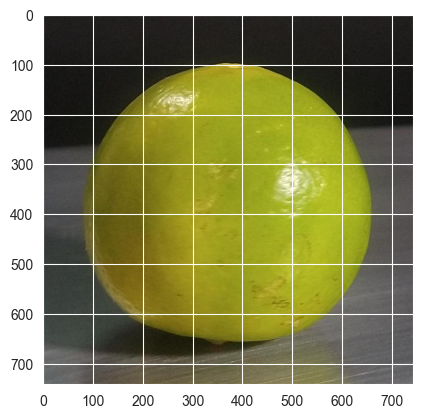

In [11]:
fpath = r"dataset/test/LIMON_CRIOLLO/0_lb0.jpg"
img = plt.imread(fpath)
print(img.shape)
imshow(img)

In [12]:
sdir = r"dataset"
train_df, test_df, valid_df = preprocess(sdir, 0.9)

train_df length:  16802   test_df length:  2069   valid_df length:  1867
labels
LIMON_TAHITI            2767
LIMON_MANDARINO         2195
NARANJA_VALENCIA        2138
MANDARINA_PIELDESAPO    2090
LIMON_CRIOLLO           2030
MANDARINA_ISRAELI       2005
TORONJA                 1888
TANGELO                 1689
Name: count, dtype: int64


In [13]:
max_samples = 300
min_samples = 0
column = "labels"
working_dir = r"./"
img_size = (224, 224)
ndf = balance(train_df, max_samples, min_samples, column, working_dir, img_size)

[300, 300, 300, 300, 300, 300, 300, 300]
[300, 300, 300, 300, 300, 300, 300, 300]


The dataframe is now balanced with 300 samples per class<br />
create train, test and validation generators

In [14]:
channels = 3
batch_size = 30
img_shape = (img_size[0], img_size[1], channels)
length = len(test_df)
test_batch_size = sorted(
    [
        int(length / n)
        for n in range(1, length + 1)
        if length % n == 0 and length / n <= 80
    ],
    reverse=True,
)[0]
test_steps = int(length / test_batch_size)
print("test batch size: ", test_batch_size, "  test steps: ", test_steps)


def scalar(img):
    return img


trgen = ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
tvgen = ImageDataGenerator(preprocessing_function=scalar)
train_gen = trgen.flow_from_dataframe(
    ndf,
    x_col="filepaths",
    y_col="labels",
    target_size=img_size,
    class_mode="categorical",
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size,
)
test_gen = tvgen.flow_from_dataframe(
    test_df,
    x_col="filepaths",
    y_col="labels",
    target_size=img_size,
    class_mode="categorical",
    color_mode="rgb",
    shuffle=False,
    batch_size=test_batch_size,
)

valid_gen = tvgen.flow_from_dataframe(
    valid_df,
    x_col="filepaths",
    y_col="labels",
    target_size=img_size,
    class_mode="categorical",
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size,
)
classes = list(train_gen.class_indices.keys())
class_count = len(classes)
train_steps = int(np.ceil(len(train_gen.labels) / batch_size))

test batch size:  1   test steps:  2069
Found 2400 validated image filenames belonging to 8 classes.
Found 2069 validated image filenames belonging to 8 classes.
Found 1867 validated image filenames belonging to 8 classes.


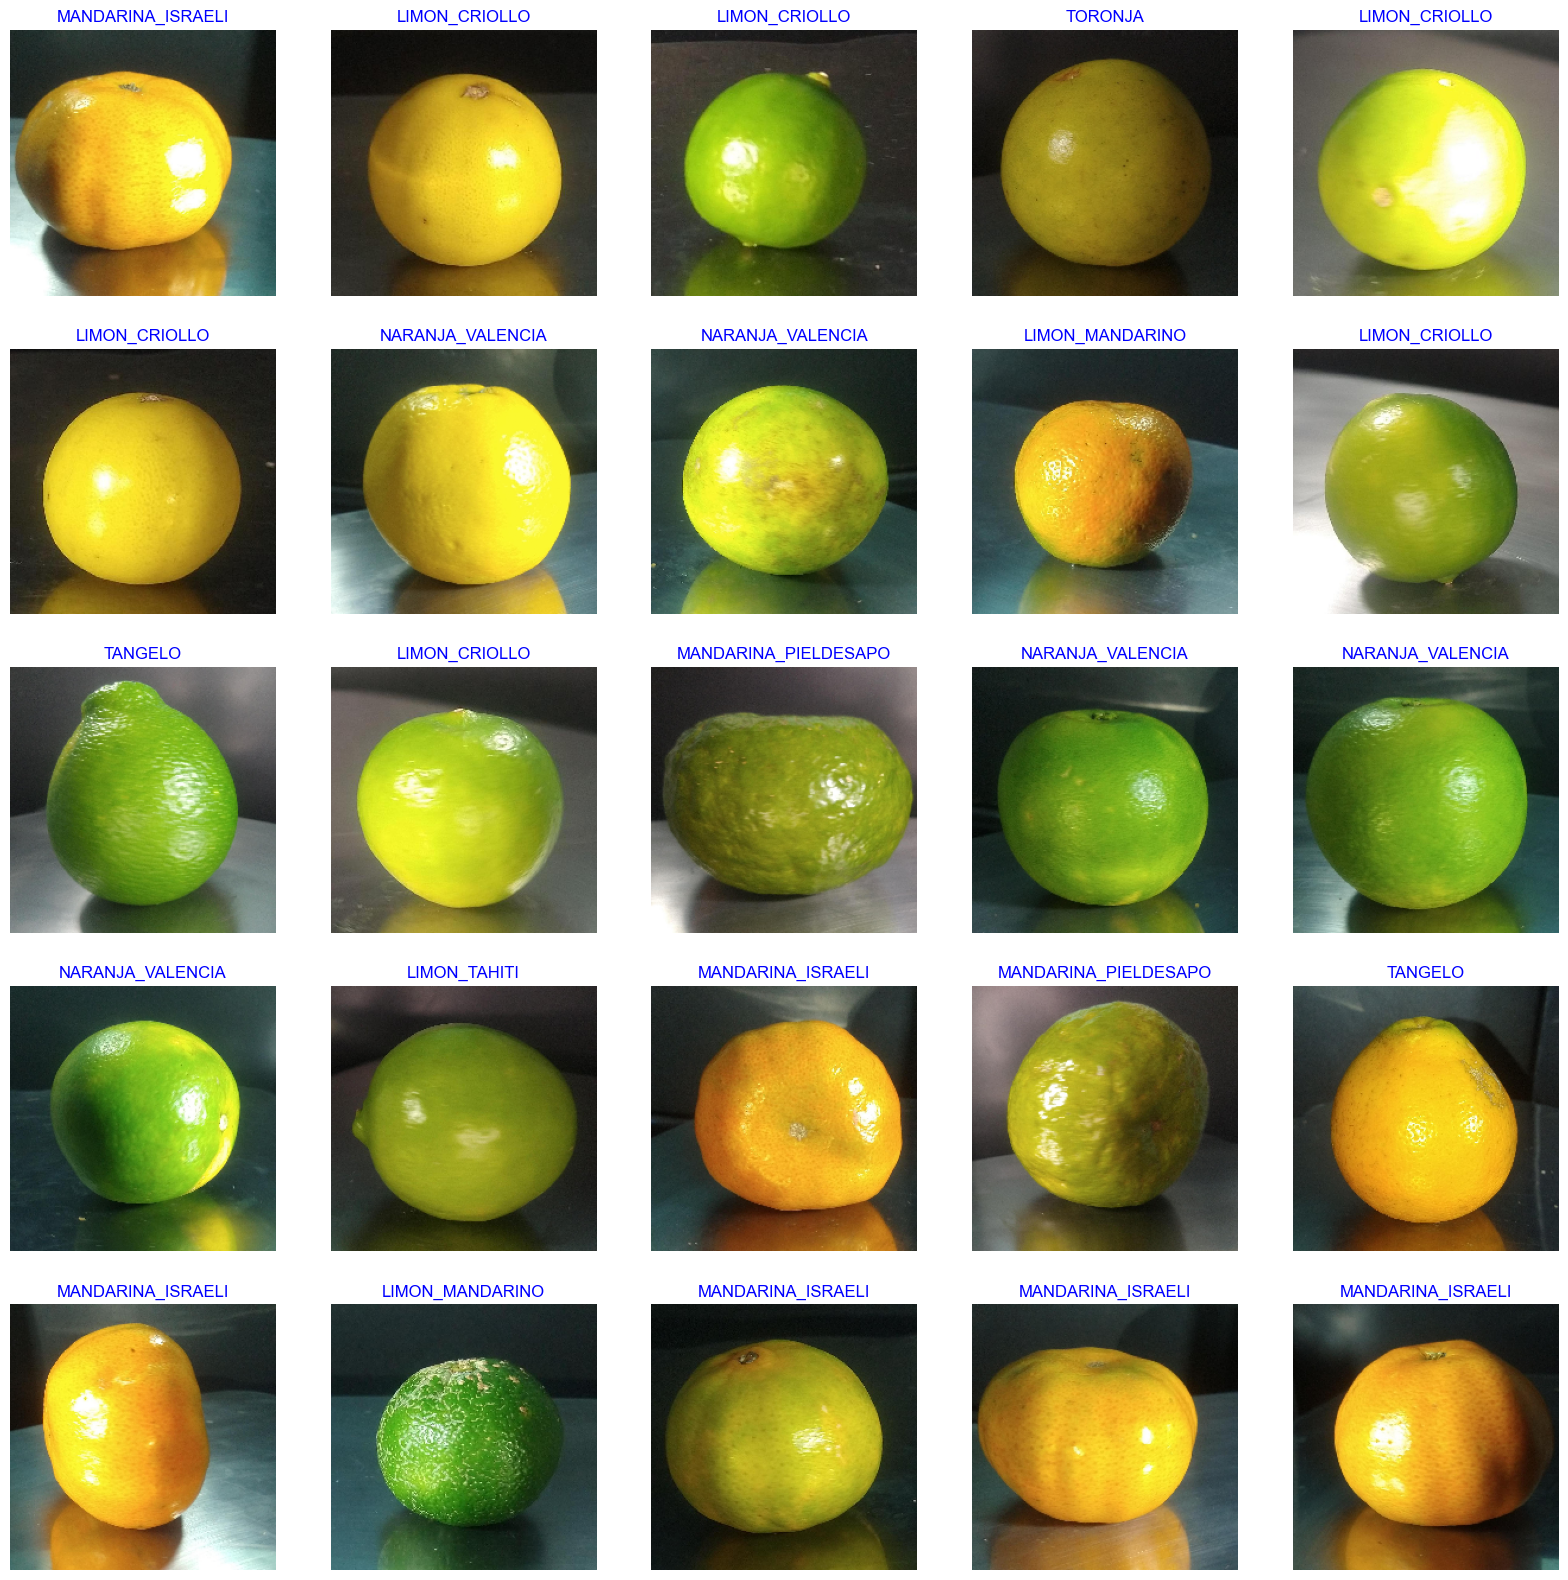

In [15]:
show_image_samples(train_gen)

# 4. Define the models

**MobileNet**

In [16]:
model1_name = "MobileNet"
mobile_net = MobileNet(weights="imagenet", include_top=False, input_shape=img_shape)
x = mobile_net.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
output = Dense(class_count, activation="softmax")(x)
mobile_net_model = Model(inputs=mobile_net.input, outputs=output)

**InceptionV3**

In [17]:
model2_name = "InceptionV3"
inception_v3 = InceptionV3(weights="imagenet", include_top=False, input_shape=img_shape)
x = inception_v3.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
output = Dense(class_count, activation="softmax")(x)
inception_v3_model = Model(inputs=inception_v3.input, outputs=output)

**MobileNet** Summary

In [18]:
mobile_net_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

**InceptionV3** Summary

In [19]:
inception_v3_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                           

# 5. Compile and Train models

In [20]:
mobile_net_model.compile(Adamax(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])
inception_v3_model.compile(Adamax(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

**Train the models**

In [21]:
mobile_net_history = mobile_net_model.fit(train_gen, epochs=25, validation_data=valid_gen)

Epoch 1/25
80/80 [==============================] - 54s 591ms/step - loss: 0.2500 - accuracy: 0.9212 - val_loss: 0.9650 - val_accuracy: 0.7167
Epoch 2/25
80/80 [==============================] - 32s 395ms/step - loss: 0.0273 - accuracy: 0.9879 - val_loss: 0.1705 - val_accuracy: 0.9379
Epoch 3/25
80/80 [==============================] - 32s 404ms/step - loss: 0.0090 - accuracy: 0.9975 - val_loss: 0.0237 - val_accuracy: 0.9888
Epoch 4/25
80/80 [==============================] - 32s 403ms/step - loss: 0.0027 - accuracy: 0.9996 - val_loss: 0.0045 - val_accuracy: 0.9989
Epoch 5/25
80/80 [==============================] - 32s 401ms/step - loss: 0.0045 - accuracy: 0.9992 - val_loss: 0.0053 - val_accuracy: 0.9984
Epoch 6/25
80/80 [==============================] - 43s 539ms/step - loss: 0.0020 - accuracy: 0.9996 - val_loss: 0.0042 - val_accuracy: 0.9989
Epoch 7/25
80/80 [==============================] - 45s 561ms/step - loss: 0.0014 - accuracy: 0.9996 - val_loss: 0.0038 - val_accuracy: 0.9989

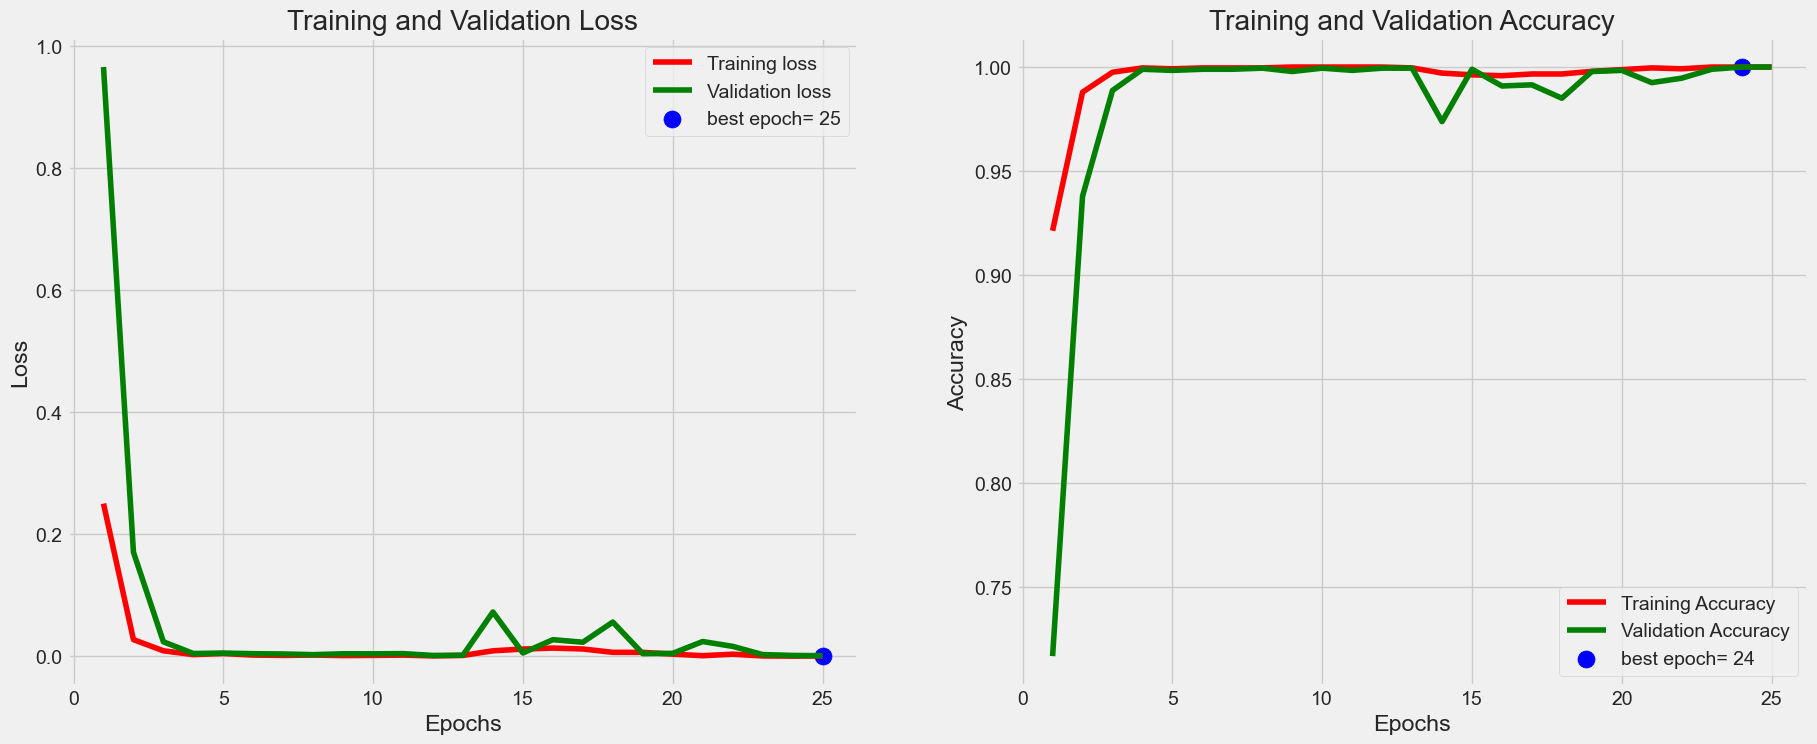

2069/2069 [==============================] - 24s 11ms/step - loss: 0.0029 - accuracy: 0.9985
accuracy on the test set is 99.85 %

model was saved as ./MobileNet-citrus-99.85.h5

class csv file was saved as ./class_dict.csv



In [22]:
tr_plot(mobile_net_history, 0)
subject = "citrus"
acc = (mobile_net_model.evaluate(test_gen, verbose=1, steps=test_steps, return_dict=False)[1] * 100)
msg = f"accuracy on the test set is {acc:5.2f} %"
print_in_color(msg, (0, 255, 0), (55, 65, 80))
generator = train_gen
scale = 1
model_save_loc, csv_save_loc = saver(working_dir, mobile_net_model, model1_name, subject, acc, img_size, scale, generator)

In [23]:
inception_v3_history = inception_v3_model.fit(train_gen, epochs=25, validation_data=valid_gen)

Epoch 1/25
80/80 [==============================] - 63s 676ms/step - loss: 0.3917 - accuracy: 0.8746 - val_loss: 5.1085 - val_accuracy: 0.4156
Epoch 2/25
80/80 [==============================] - 52s 648ms/step - loss: 0.1207 - accuracy: 0.9604 - val_loss: 0.5585 - val_accuracy: 0.8543
Epoch 3/25
80/80 [==============================] - 52s 652ms/step - loss: 0.0439 - accuracy: 0.9854 - val_loss: 0.0379 - val_accuracy: 0.9866
Epoch 4/25
80/80 [==============================] - 52s 651ms/step - loss: 0.0328 - accuracy: 0.9892 - val_loss: 0.0192 - val_accuracy: 0.9925
Epoch 5/25
80/80 [==============================] - 52s 647ms/step - loss: 0.0149 - accuracy: 0.9942 - val_loss: 0.0124 - val_accuracy: 0.9963
Epoch 6/25
80/80 [==============================] - 52s 652ms/step - loss: 0.0052 - accuracy: 0.9992 - val_loss: 0.0293 - val_accuracy: 0.9914
Epoch 7/25
80/80 [==============================] - 52s 649ms/step - loss: 0.0181 - accuracy: 0.9950 - val_loss: 0.2773 - val_accuracy: 0.9116

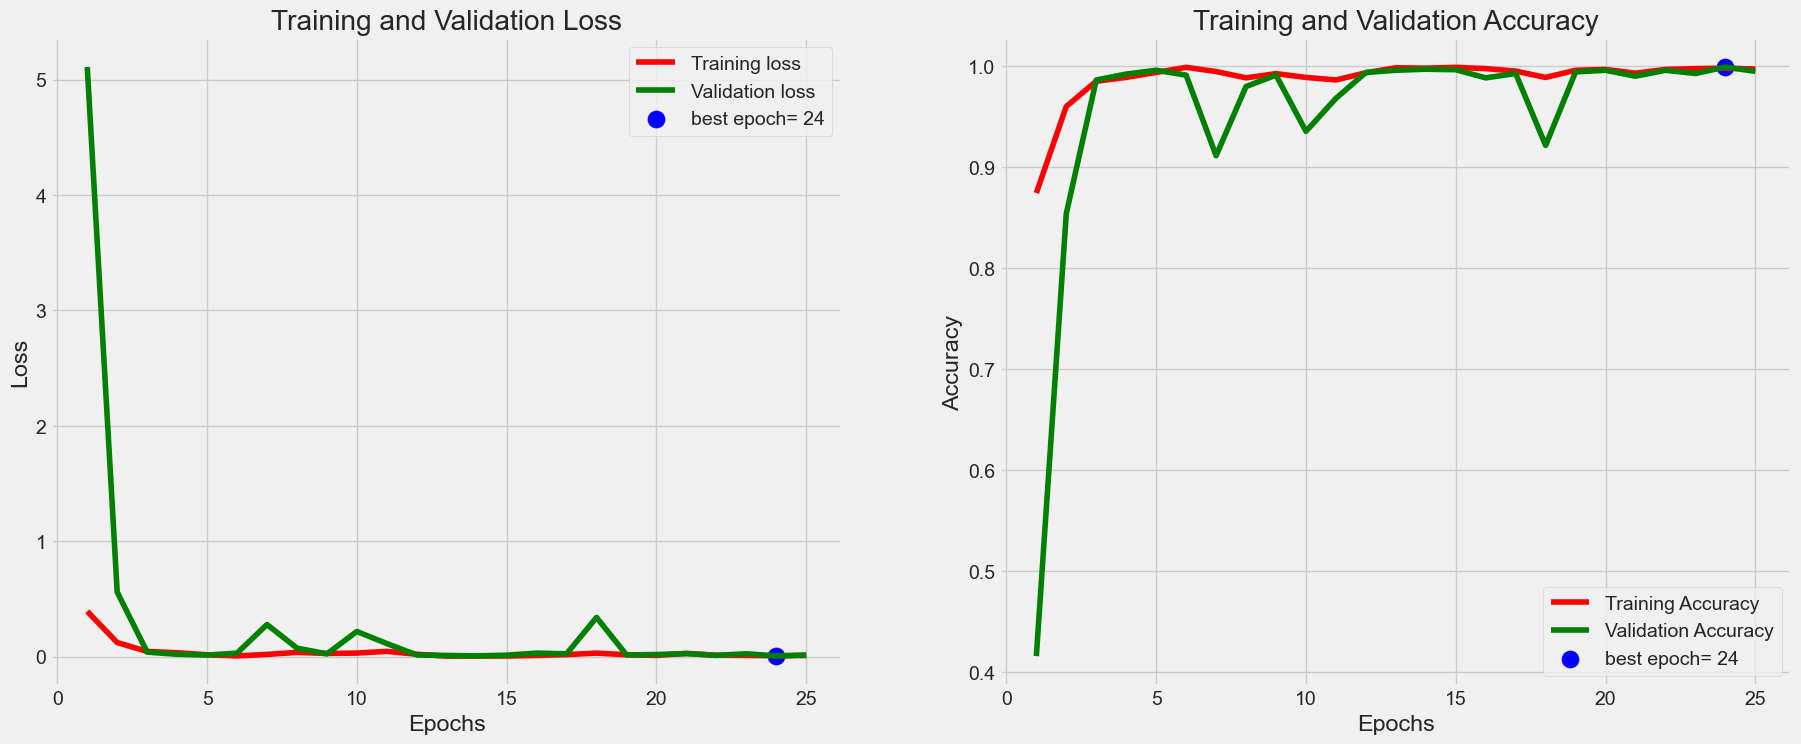

2069/2069 [==============================] - 41s 20ms/step - loss: 0.0139 - accuracy: 0.9957
accuracy on the test set is 99.57 %

model was saved as ./InceptionV3-citrus-99.56.h5

class csv file was saved as ./class_dict.csv



In [24]:
tr_plot(inception_v3_history, 0)
subject = "citrus"
acc = (inception_v3_model.evaluate(test_gen, verbose=1, steps=test_steps, return_dict=False)[1] * 100)
msg = f"accuracy on the test set is {acc:5.2f} %"
print_in_color(msg, (0, 255, 0), (55, 65, 80))
generator = train_gen
scale = 1
model_save_loc, csv_save_loc = saver(working_dir, inception_v3_model, model2_name, subject, acc, img_size, scale, generator)

# 6. make predictions on test set and generate confusion matrix and classification report

2069/2069 [==============================] - 15s 7ms/step


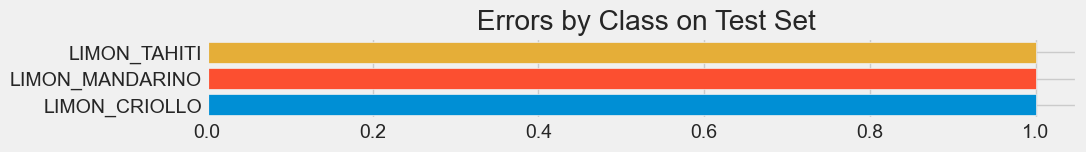

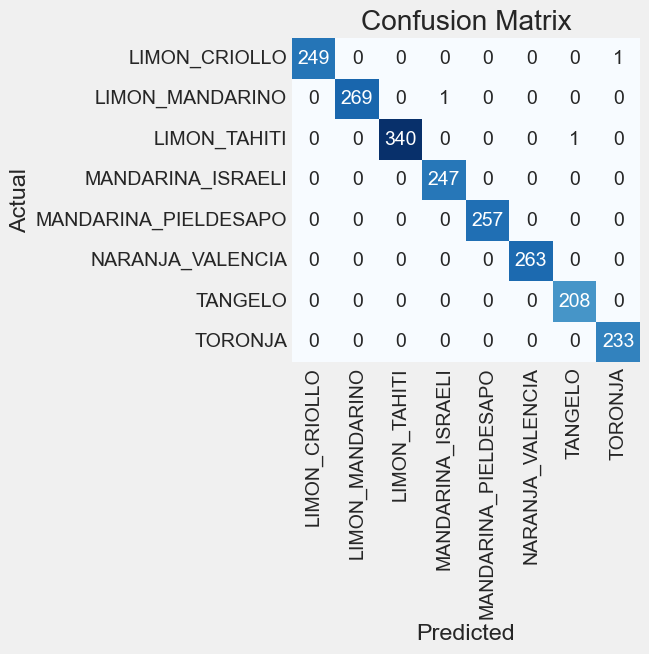

Classification Report:
----------------------
                       precision    recall  f1-score   support

       LIMON_CRIOLLO       1.00      1.00      1.00       250
     LIMON_MANDARINO       1.00      1.00      1.00       270
        LIMON_TAHITI       1.00      1.00      1.00       341
   MANDARINA_ISRAELI       1.00      1.00      1.00       247
MANDARINA_PIELDESAPO       1.00      1.00      1.00       257
    NARANJA_VALENCIA       1.00      1.00      1.00       263
             TANGELO       1.00      1.00      1.00       208
             TORONJA       1.00      1.00      1.00       233

            accuracy                           1.00      2069
           macro avg       1.00      1.00      1.00      2069
        weighted avg       1.00      1.00      1.00      2069



In [25]:
print_code = 0
preds = mobile_net_model.predict(test_gen, steps=test_steps, verbose=1)
print_info(test_gen, preds, print_code, working_dir, subject)

2069/2069 [==============================] - 38s 18ms/step


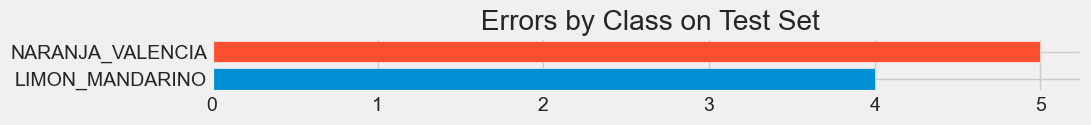

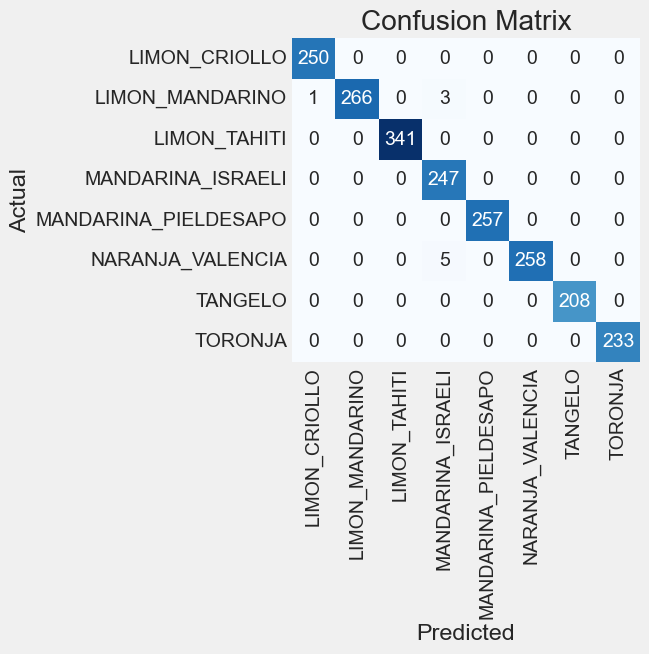

Classification Report:
----------------------
                       precision    recall  f1-score   support

       LIMON_CRIOLLO       1.00      1.00      1.00       250
     LIMON_MANDARINO       1.00      0.99      0.99       270
        LIMON_TAHITI       1.00      1.00      1.00       341
   MANDARINA_ISRAELI       0.97      1.00      0.98       247
MANDARINA_PIELDESAPO       1.00      1.00      1.00       257
    NARANJA_VALENCIA       1.00      0.98      0.99       263
             TANGELO       1.00      1.00      1.00       208
             TORONJA       1.00      1.00      1.00       233

            accuracy                           1.00      2069
           macro avg       1.00      1.00      1.00      2069
        weighted avg       1.00      1.00      1.00      2069



In [26]:
print_code = 0
preds = inception_v3_model.predict(test_gen, steps=test_steps, verbose=1)
print_info(test_gen, preds, print_code, working_dir, subject)

# 7. Evaluate the models

In [37]:
mobile_net_loss, mobile_net_acc = mobile_net_model.evaluate(valid_gen)
inception_v3_loss, inception_v3_acc = inception_v3_model.evaluate(valid_gen)

mobile_net_y_pred = mobile_net_model.predict(valid_gen)
inception_v3_y_pred = inception_v3_model.predict(valid_gen)

mobile_net_y_true = valid_gen.classes
inception_v3_y_true = valid_gen.classes

mobile_net_precision = precision_score(mobile_net_y_true, np.argmax(mobile_net_y_pred, axis=1), average="macro")
inception_v3_precision = precision_score(inception_v3_y_true, np.argmax(inception_v3_y_pred, axis=1), average="macro")

mobile_net_recall = recall_score(mobile_net_y_true, np.argmax(mobile_net_y_pred, axis=1), average="macro")
inception_v3_recall = recall_score(inception_v3_y_true, np.argmax(inception_v3_y_pred, axis=1), average="macro")

mobile_net_f1 = f1_score(mobile_net_y_true, np.argmax(mobile_net_y_pred, axis=1), average="macro")
inception_v3_f1 = f1_score(inception_v3_y_true, np.argmax(inception_v3_y_pred, axis=1), average="macro")


print(f"MobileNet Accuracy: {mobile_net_acc:.2f}")
print(f"InceptionV3 Accuracy: {inception_v3_acc:.2f}")
print("")
print(f"MobileNet Precision: {mobile_net_precision:.4f}")
print(f"InceptionV3 Precision: {inception_v3_precision:.4f}")
print("")
print(f"MobileNet Recall: {mobile_net_recall:.4f}")
print(f"InceptionV3 Recall: {inception_v3_recall:.4f}")
print("")
print(f"MobileNet f1-score: {mobile_net_f1:.4f}")
print(f"InceptionV3 f1-score: {inception_v3_f1:.4f}")

63/63 [==============================] - 12s 184ms/step
MobileNet Accuracy: 1.00
InceptionV3 Accuracy: 1.00

MobileNet Precision: 0.1139
InceptionV3 Precision: 0.1303

MobileNet Recall: 0.1139
InceptionV3 Recall: 0.1303

MobileNet f1-score: 0.1139
InceptionV3 f1-score: 0.1303


# 8. Test the classifier kernel create a directory with a single image in it

In [35]:
store_path = os.path.join(working_dir, "storage")
if os.path.isdir(store_path):
    shutil.rmtree(store_path)
os.mkdir(store_path)
# input an image of LIMON_CRIOLLO
img_path = r"dataset/test/TANGELO/202_lb6.jpg"
img = cv2.imread(img_path, cv2.IMREAD_REDUCED_COLOR_2)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# model was trained on rgb images so convert image to rgb
file_name = os.path.split(img_path)[1]
dst_path = os.path.join(store_path, file_name)
cv2.imwrite(dst_path, img)
# check if the directory was created and image stored
print(os.listdir(store_path))

['202_lb6.jpg']


use the predictor function to classify the single image

 Model is being loaded- this will take about 10 seconds
1/1 [==============================] - 1s 968ms/step
 image is of  TANGELO with a probability of  100.00 %



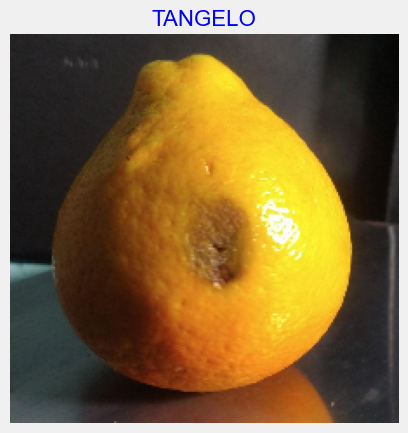

In [36]:
csv_path = csv_save_loc  # path to class_dict.csv
model_path = model_save_loc  # path to the trained model
class_name, probability = predictor(
    store_path, csv_path, model_path, crop_image=False
)  # run the classifier
msg = f" image is of  {class_name} with a probability of {probability * 100: 6.2f} %"
print_in_color(msg, (0, 255, 255), (65, 85, 55))